In [1]:
import pandas as pd
from environment import root_dir
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
import seaborn as sns

In [2]:
task_vis_results = pd.read_pickle(f"{root_dir}/results/results-tree-vis.pkl")
generation_results = pd.read_pickle(f"{root_dir}/results/results-generation.pkl")
compare_results = pd.read_pickle(f"{root_dir}/results/results-tree-compare.pkl")

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [4]:
models = {
    "deepseek-ai/deepseek-reasoner": {
        "label": "DeepsSeek-R1", 
        "color": colors[0],
    }, 
    "deepseek-ai/deepseek-chat": {
        "label": "DeepSeek-V3", 
        "color": colors[1],
    },
    "openrouter-qwen/qwq-32b": {
        "label": "QwQ-32B", 
        "color": colors[2],
    },    
    "alibaba/qwen2.5-32b-instruct": {
        "label": "Qwen2.5-32B", 
        "color": colors[3],
    },
}

dataset = "gpqa-diamond"

In [5]:
def get_row(df, **kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

In [6]:
pass1 = {}
reasoning_metrics = {"avg_depth": {}, "breadth": {}, "b2d_ratio": {}, "validation_rate": {}}

for model in models:
    row = get_row(
        generation_results, 
        model_name=model.replace("/", "-"), 
        dataset_name=dataset, 
    )
    pass1[model] = row.iloc[0]["pass@1"]
    
    row = get_row(
        task_vis_results, 
        model_name=model, 
        dataset_name=dataset, 
    )
    for metric in reasoning_metrics:
        reasoning_metrics[metric][model] = row.iloc[0][metric]
    
    


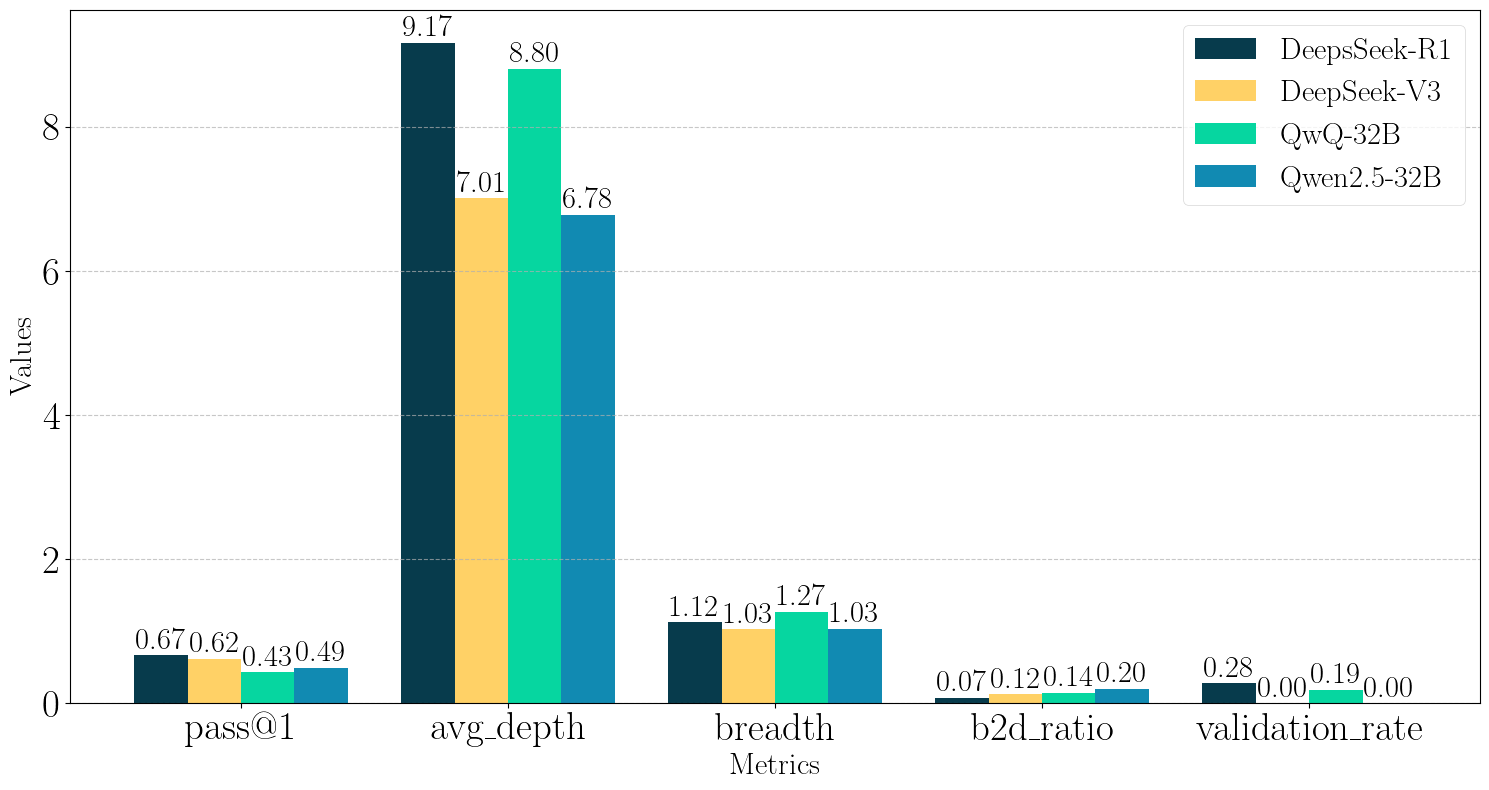

In [7]:


# Prepare data for plotting
metrics = {
    "pass@1": pass1,
    "avg_depth": reasoning_metrics["avg_depth"],
    "breadth": reasoning_metrics["breadth"],
    "b2d_ratio": reasoning_metrics["b2d_ratio"],
    "validation_rate": reasoning_metrics["validation_rate"]
}

# Get model names
model_names = list(models.keys())

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Number of metrics and models
n_metrics = len(metrics)
n_models = len(model_names)
width = 0.8 / n_models  # Width of each bar

# Set positions for bars
positions = np.arange(n_metrics)

# Plot bars for each model
for i, model in enumerate(model_names):
    # Collect values for this model across all metrics
    values = [metrics[metric][model] if model in metrics[metric] else 0 for metric in metrics]
    
    # Calculate position for this model's bars
    model_positions = positions + (i - n_models/2 + 0.5) * width
    
    # Plot bars
    bars = ax.bar(model_positions, values, width, label=models[model]["label"], color=models[model]["color"])
    
    # Add value labels on top of bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.2f}', ha='center', va='bottom', fontsize=22)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=22)
ax.set_ylabel('Values', fontsize=22)
# ax.set_title(f'Model Performance Comparison on {dataset}', fontsize=14)

# Set x-tick positions and labels
ax.set_xticks(positions)
ax.set_xticklabels(list(metrics.keys()))

# Add legend
ax.legend(fontsize=22)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [8]:
model_pairs = list(itertools.combinations(models, 2))
distances = {}

for model_pair in model_pairs:
    model1, model2 = sorted(model_pair)
    row = get_row(
        compare_results,
        model1=model1,
        model2=model2,
        dataset=dataset,
    )
    distances[(model1, model2)] = row.iloc[0]["distance"]
    
    

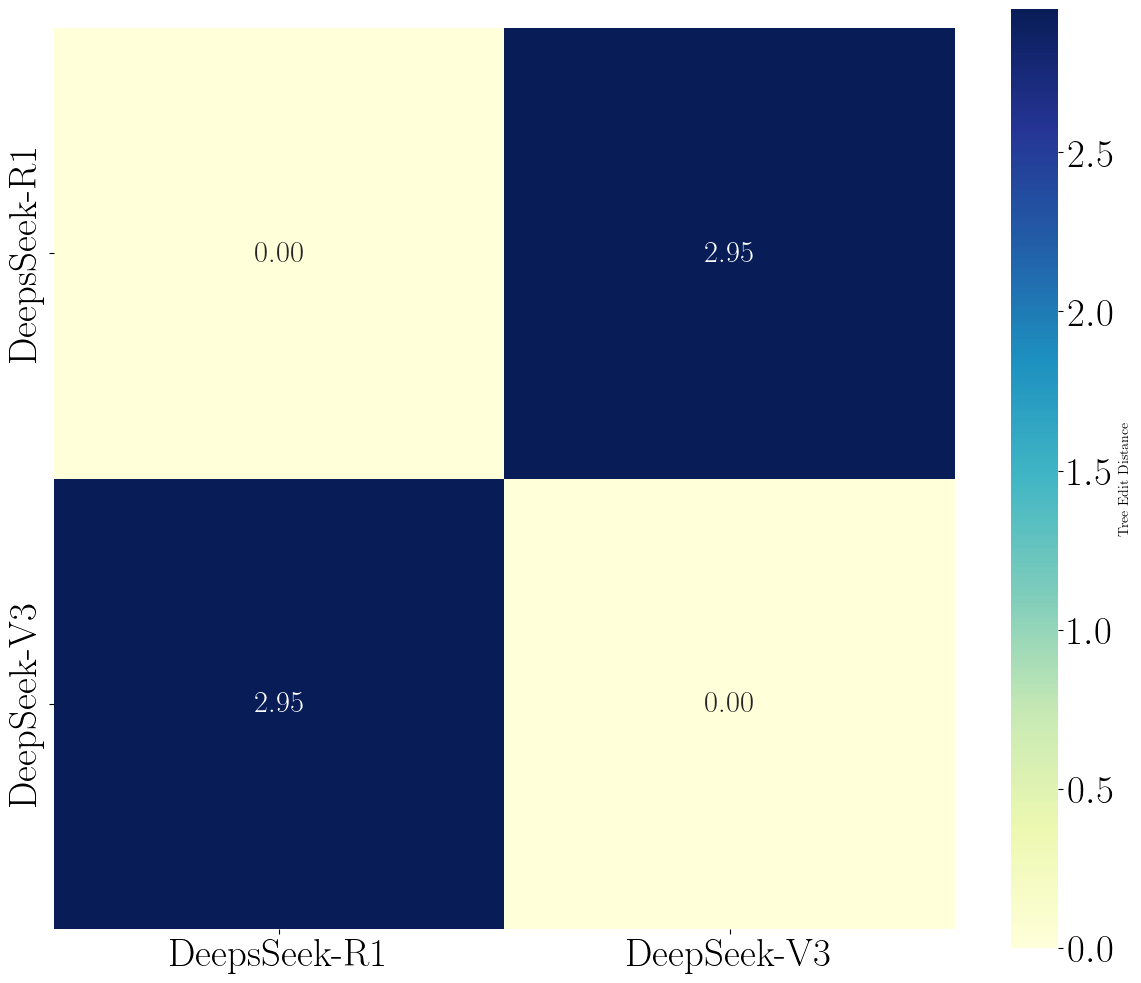

In [9]:
# Create a heatmap to visualize distances between model pairs
model_names = list(models.keys())
n_models = len(model_names)

# Create a distance matrix
distance_matrix = np.zeros((n_models, n_models))

# Fill the distance matrix
for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i == j:
            # Distance to self is 0
            distance_matrix[i, j] = 0
        else:
            # Get the sorted pair to match our distances dictionary keys
            sorted_pair = tuple(sorted([model1, model2]))
            if sorted_pair in distances:
                distance_matrix[i, j] = distances[sorted_pair]

# Create figure and axis
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(
    distance_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    xticklabels=[models[model]["label"] for model in model_names],
    yticklabels=[models[model]["label"] for model in model_names],
    square=True,
    annot_kws={"size": 22},
    cbar_kws={"label": "Tree Edit Distance"},
)

plt.tight_layout()
plt.show()
